In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [28]:
def give_quarter_performance(Predictions,Labels,quarter):
    quarter = str(quarter)
    Q = Predictions[quarter]
    Q_labels = Labels[quarter]
    Q = Q.sort_values(ascending=False)
    Q_top_30 = Q[:30]
    
    top_30_labels = []

    for index in Q_top_30.index:
        row = Q_labels.loc[index]
        top_30_labels.append(row)
    
    labels_series = pd.Series(top_30_labels)
    final_df = pd.DataFrame({'Preds': Q_top_30.values,'Labels': labels_series.values},index=Q_top_30.index)
    
    return final_df

def quarter_performance(Quarter_result):    
    portfolio_start = 30
    portfolio_end = 0
    for value in Quarter_result['Labels'].values:
        portfolio_end = portfolio_end + 1 + value
    
    perfomance = ((portfolio_end-portfolio_start)/portfolio_start)*100
    return perfomance
        
def total_performance(num_quarters,Predictions,labels_df, model):
    total_returns = 100
    q_turnouts = [100]
    q_pers = []
    for quarter in range(num_quarters):
        Q_result = give_quarter_performance(Predictions,labels_df,quarter)
        Q_per = quarter_performance(Q_result)
        
        total_returns = total_returns * (1+(Q_per/100))
        print('Quarter '+str(quarter+1)+' Result :' +str("%.2f" % Q_per)+' %')
        q_turnouts.append(total_returns)
        q_pers.append(Q_per)
    
    compounded_result = total_returns-100
    q_avg_return = (pow(total_returns/100, 1/num_quarters) - 1) * 100
    CAGR = (pow(total_returns/100, 1/(num_quarters/4)) - 1) * 100
    
    print('Compounded Result :'+str("%.2f" % compounded_result)+str(' %'))
    print('Quarterly Compounded Growth Rate :',"%.2f" % q_avg_return, '%')
    print('CAGR :',"%.2f" %  CAGR, '%')
    print('Sharpe Ratio :',"%.2f" %  ((4**0.5) * q_avg_return/np.std(q_pers)))    
    
    positives = []
    for q_per in q_pers:
        if q_per >0:
            positives.append(True)
        else:
            positives.append(False)
            
    positives = pd.Series(positives)
    
#     f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
#     ax1.plot(x, y)
#     ax1.set_title('Sharing Y axis')
#     ax2.scatter(x, y)

    fig = plt.figure(figsize=(15,4))
    title = fig.suptitle('Portfolio Performance of '+str(model)+' model')
    
    ax1 = fig.add_subplot(1,2,1)
    ax1.bar(np.arange(1,len(q_pers)+1),q_pers,color=positives.map({True: 'g', False: 'r'}),width = 0.5)
    ax1.axhline(0,color='black')
    ax1.set_ylabel('Percentage Returns across Quarters')
    ax1.set_xlabel('Quarters')
    
    
    ax2 = fig.add_subplot(1,2,2)
    ax2.plot(np.arange(1,len(q_turnouts)+1),q_turnouts,label = 'Portolio Value',color = 'green')
    ax2.set_xlabel('Quarters')
    ax2.set_ylabel('Portfolio Value for 100$ Invested')
    plt.show() 
    
    return compounded_result

Quarter 1 Result :8.88 %
Quarter 2 Result :7.61 %
Quarter 3 Result :5.60 %
Quarter 4 Result :4.93 %
Quarter 5 Result :5.68 %
Quarter 6 Result :-2.77 %
Quarter 7 Result :0.94 %
Quarter 8 Result :9.07 %
Compounded Result :46.88 %
Quarterly Compounded Growth Rate : 4.92 %
CAGR : 21.19 %
Sharpe Ratio : 2.58


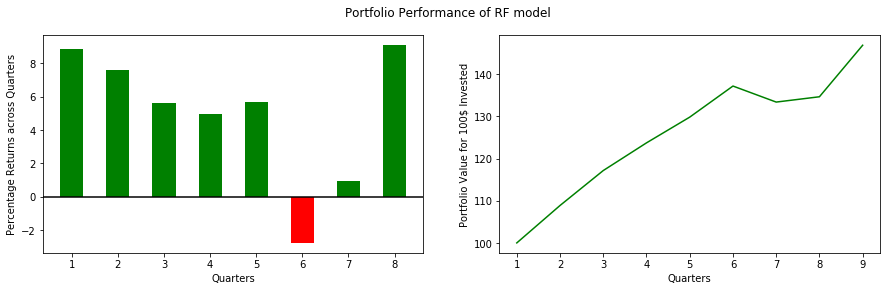

Quarter 1 Result :7.77 %
Quarter 2 Result :6.01 %
Quarter 3 Result :4.99 %
Quarter 4 Result :3.81 %
Quarter 5 Result :8.55 %
Quarter 6 Result :-6.78 %
Quarter 7 Result :-2.48 %
Quarter 8 Result :11.03 %
Compounded Result :36.42 %
Quarterly Compounded Growth Rate : 3.96 %
CAGR : 16.80 %
Sharpe Ratio : 1.42


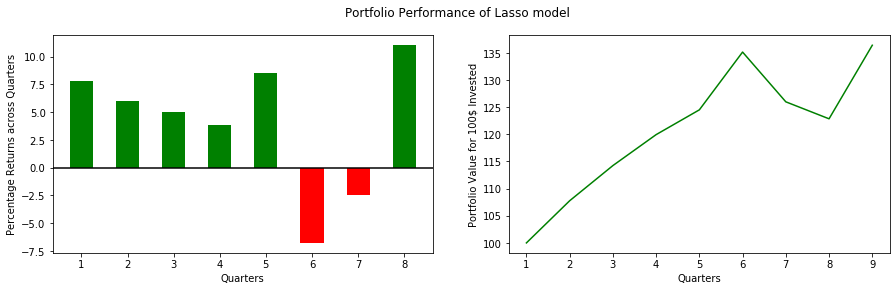

Quarter 1 Result :7.60 %
Quarter 2 Result :8.37 %
Quarter 3 Result :4.73 %
Quarter 4 Result :1.69 %
Quarter 5 Result :5.78 %
Quarter 6 Result :-5.04 %
Quarter 7 Result :-2.80 %
Quarter 8 Result :8.34 %
Compounded Result :31.38 %
Quarterly Compounded Growth Rate : 3.47 %
CAGR : 14.62 %
Sharpe Ratio : 1.44


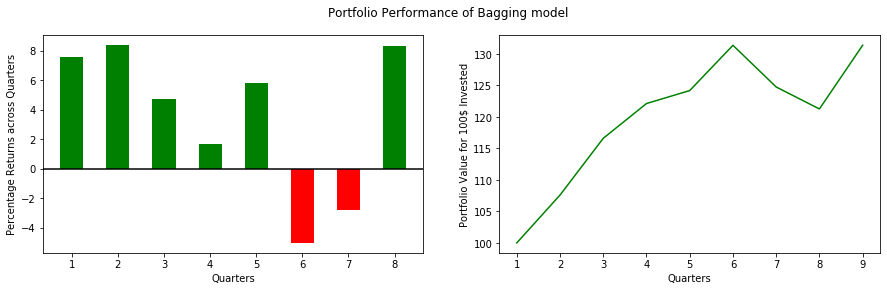

Quarter 1 Result :7.56 %
Quarter 2 Result :6.07 %
Quarter 3 Result :6.40 %
Quarter 4 Result :1.59 %
Quarter 5 Result :6.65 %
Quarter 6 Result :-5.83 %
Quarter 7 Result :-3.52 %
Quarter 8 Result :7.58 %
Compounded Result :28.57 %
Quarterly Compounded Growth Rate : 3.19 %
CAGR : 13.39 %
Sharpe Ratio : 1.28


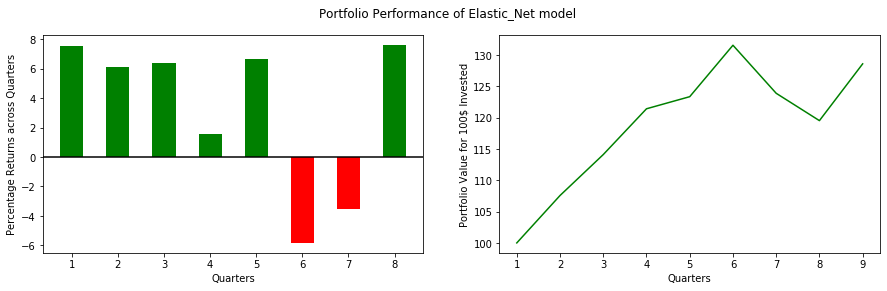

Quarter 1 Result :6.43 %
Quarter 2 Result :5.55 %
Quarter 3 Result :2.56 %
Quarter 4 Result :5.98 %
Quarter 5 Result :3.13 %
Quarter 6 Result :-8.84 %
Quarter 7 Result :-1.77 %
Quarter 8 Result :7.72 %
Compounded Result :21.47 %
Quarterly Compounded Growth Rate : 2.46 %
CAGR : 10.22 %
Sharpe Ratio : 0.96


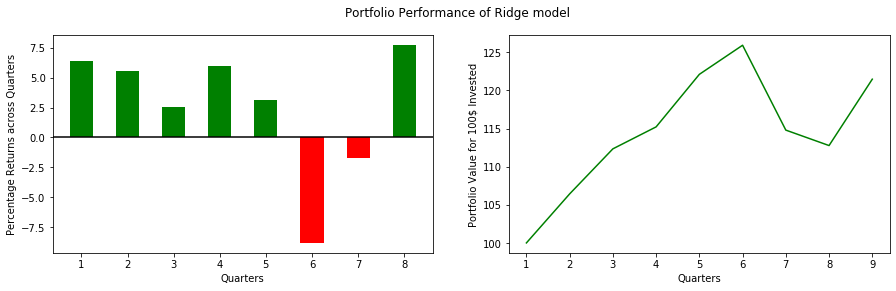

Quarter 1 Result :7.79 %
Quarter 2 Result :3.14 %
Quarter 3 Result :3.08 %
Quarter 4 Result :-2.02 %
Quarter 5 Result :3.26 %
Quarter 6 Result :-7.49 %
Quarter 7 Result :-1.98 %
Quarter 8 Result :8.46 %
Compounded Result :14.03 %
Quarterly Compounded Growth Rate : 1.65 %
CAGR : 6.78 %
Sharpe Ratio : 0.66


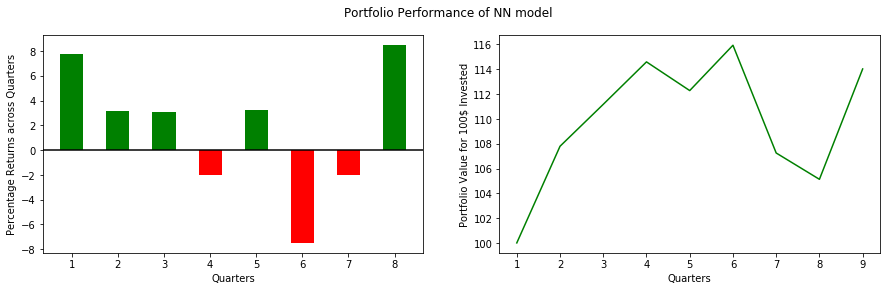

In [29]:
Models = ['RF','Lasso','Bagging','Elastic_Net','Ridge','NN']
Agg_Models = ['Lasso','RF','Bagging','Elastic_Net']
Labels = pd.read_csv('./Labels_and_Preds/Labels.csv',delimiter =',',index_col = 'Unnamed: 0')
Model_Results = []

for model in Models:
    Preds = pd.read_csv('./Labels_and_Preds/Predictions_'+model+'.csv', delimiter = ',', index_col = 'Unnamed: 0')
    Model_Results.append(total_performance(8,Preds,Labels,model))

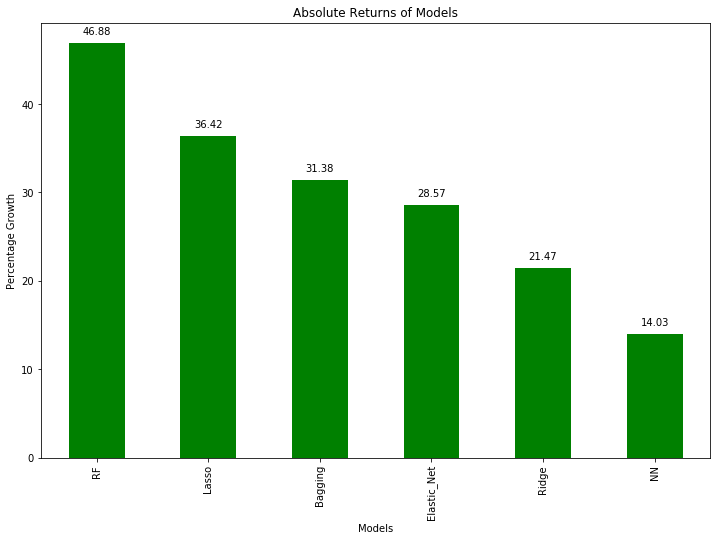

In [30]:
Model_Results = pd.Series(Model_Results)

plt.figure(figsize=(12, 8))
ax = Model_Results.plot(kind='bar', color = 'green')
ax.set_title('Absolute Returns of Models')
ax.set_xlabel('Models')
ax.set_ylabel('Percentage Growth')
ax.set_xticklabels(Models)

rects = ax.patches

# Make some labels.
labels = ["%.2f" % val for val in Model_Results.values]

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 0.75, label,
            ha='center', va='bottom')



# Aggregation

In [31]:
def aggregate(Models,num_quarters):
    model_dfs = []
    for model in Models:
        Preds = pd.read_csv('./Labels_and_Preds/Predictions_'+model+'.csv', delimiter = ',', index_col = 'Unnamed: 0')
        model_df = pd.DataFrame()
        for quarter in range(num_quarters):
            Q_portfolio = give_quarter_performance(Preds,Labels,quarter)
            temp_df = pd.DataFrame(Q_portfolio.index)
            model_df = pd.concat([model_df,temp_df], ignore_index= True, axis =1)

        model_dfs.append(model_df)
        
    return model_dfs

In [32]:
Agg_Models = ['Lasso','RF','NN']
Q = aggregate(Agg_Models,8)

In [33]:
'''
0: Lasso
1: NN
2: RF
3: Elastic Net
4: Bagging
5: Ridge
'''

'\n0: Lasso\n1: NN\n2: RF\n3: Elastic Net\n4: Bagging\n5: Ridge\n'

In [34]:
import operator
import itertools

def bootstrap_aggregate(model_outputs):
    Overall_aggregate = []
    num_quarters = model_outputs[0].shape[1]
    for i in range(num_quarters):
        Quarter_aggregate = {}
        for j in range(len(model_outputs)):
            model_portfolio = model_outputs[j][i].values
            for value in model_portfolio:
                value = str(value)
                if value in Quarter_aggregate:
                    Quarter_aggregate[value]+=1
                else:
                    Quarter_aggregate[value] = 1
                    
        Quarter_aggregate_sorted = dict( sorted(Quarter_aggregate.items(), key=operator.itemgetter(1),reverse=True))
        Quarter_aggregate_top_30 = dict(itertools.islice(Quarter_aggregate_sorted.items(), 30))
        Quarter_aggregate_df = pd.DataFrame(list(Quarter_aggregate_top_30.items()))
        Overall_aggregate.append(Quarter_aggregate_df)

    return Overall_aggregate


In [35]:
Overall_bootstrap_agg = bootstrap_aggregate(Q)

In [40]:
def aggregated_performance_top_30(Overall_bootstrap,Labels):
    num_quarters = len(Overall_bootstrap)
    
    total_returns = 100
    q_pers = []
    q_turnouts = []
    for quarter in range(num_quarters):
        assets = Overall_bootstrap[quarter][0].values
        q_performance = 0
        asset_labels = Labels[str(quarter)]
        
        for asset in assets:
            asset_performance = asset_labels.loc[(asset)] 
            q_performance = q_performance + 1 + asset_performance
            q_per = ((q_performance-30)/30)*100
        
        total_returns = total_returns * (1+(q_per/100))
        
        print('Quarter '+str(quarter+1)+' Result :' +str("%.2f" % q_per)+' %')
        q_pers.append(q_per)
        q_turnouts.append(total_returns)
    
    compounded_result = total_returns-100
    q_avg_return = (pow(total_returns/100, 1/num_quarters) - 1) * 100
    CAGR = (pow(total_returns/100, 1/(num_quarters/4)) - 1) * 100
    
    print('Compounded Result :'+str("%.2f" % compounded_result)+str(' %'))
    print('Quarterly Compounded Growth Rate :',"%.2f" % q_avg_return, '%')
    print('CAGR :',"%.2f" %  CAGR, '%')
    print('Sharpe Ratio :',"%.2f" % (4**0.5 * (q_avg_return/np.std(q_pers))))  
    
    positives = []
    for q_per in q_pers:
        if q_per >0:
            positives.append(True)
        else:
            positives.append(False)
            
    positives = pd.Series(positives)
    
    fig = plt.figure(figsize=(15,4))
    title = fig.suptitle('Portfolio Performance of Aggregated model')
    
    ax1 = fig.add_subplot(1,2,1)
    ax1.bar(np.arange(1,len(q_pers)+1),q_pers,color=positives.map({True: 'g', False: 'r'}),width = 0.5)
    ax1.axhline(0,color='black')
    ax1.set_ylabel('Percentage Returns across Quarters')
    ax1.set_xlabel('Quarters')
    
    
    ax2 = fig.add_subplot(1,2,2)
    ax2.plot(np.arange(1,len(q_turnouts)+1),q_turnouts,label = 'Portolio Value',color = 'green')
    ax2.set_xlabel('Quarters')
    ax2.set_ylabel('Portfolio Value for 100$ Invested')
    plt.show() 

Quarter 1 Result :9.07 %
Quarter 2 Result :5.57 %
Quarter 3 Result :5.51 %
Quarter 4 Result :5.42 %
Quarter 5 Result :7.58 %
Quarter 6 Result :-4.56 %
Quarter 7 Result :-1.92 %
Quarter 8 Result :9.07 %
Compounded Result :40.65 %
Quarterly Compounded Growth Rate : 4.36 %
CAGR : 18.60 %
Sharpe Ratio : 1.85


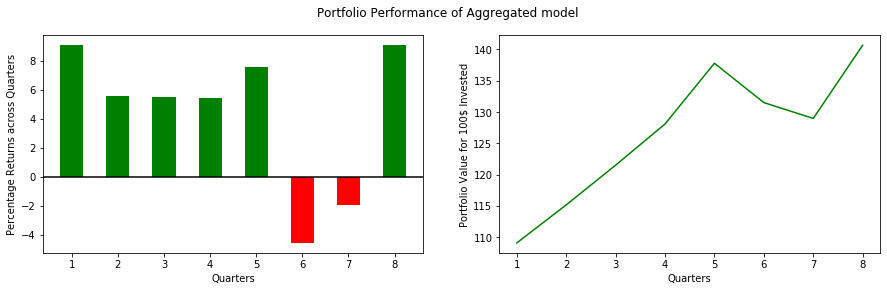

In [41]:
aggregated_performance_top_30(Overall_bootstrap_agg,Labels)

In [12]:
# thresholding done
# binarisation done
# denoising - local means, NLM, gaussian - done
# dilation - done
# erosion - done
# segmentation 
# brightness 
# contrast 
# histogram equalization - done
# linear stretching 